In [206]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report

In [207]:
import os

DATA_DIR = 'data_processed/filtered/New'
print(os.listdir(DATA_DIR))

['disgust']


In [208]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [209]:
image_size = 64
batch_size = 5
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (0.5,), (0.5,)

In [210]:




train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    transforms.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))


train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [211]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [212]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]




In [213]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

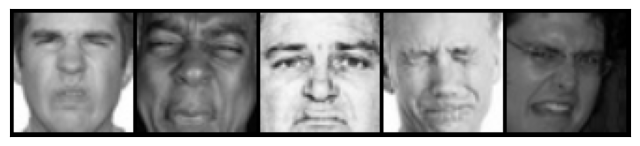

In [214]:
show_batch(train_dl)

In [215]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [216]:
device = get_default_device()
device

device(type='cuda')

In [217]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator Network

In [218]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [219]:
discriminator = to_device(discriminator, device)

In [220]:
latent_size = 160

In [221]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([5, 1, 64, 64])


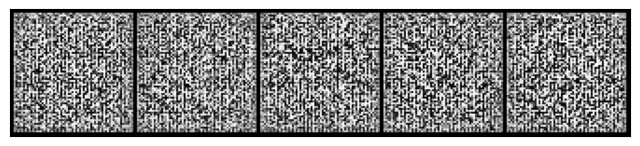

In [222]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [223]:
generator = to_device(generator, device)

In [224]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [225]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [226]:
from torchvision.utils import save_image

In [227]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [228]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [229]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


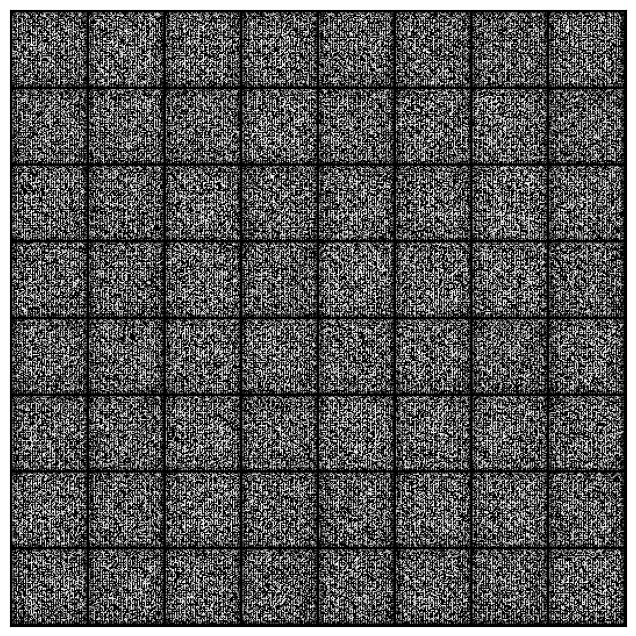

In [230]:
save_samples(0, fixed_latent)

In [231]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [232]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [233]:
lr = 0.0002
epochs = 100

In [234]:
history = fit(epochs, lr)

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 8.4899, loss_d: 0.0040, real_score: 1.0000, fake_score: 0.0040
Saving generated-images-0001.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 5.1871, loss_d: 0.0156, real_score: 1.0000, fake_score: 0.0154
Saving generated-images-0002.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 9.4845, loss_d: 0.0020, real_score: 0.9984, fake_score: 0.0004
Saving generated-images-0003.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 12.3367, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0004.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 5.3236, loss_d: 0.0255, real_score: 0.9969, fake_score: 0.0217
Saving generated-images-0005.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 8.6187, loss_d: 0.1512, real_score: 0.9522, fake_score: 0.0868
Saving generated-images-0006.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 2.1041, loss_d: 0.3824, real_score: 0.9504, fake_score: 0.2618
Saving generated-images-0007.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 4.1062, loss_d: 0.5800, real_score: 0.9951, fake_score: 0.3569
Saving generated-images-0008.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.1805, loss_d: 0.0297, real_score: 0.9885, fake_score: 0.0179
Saving generated-images-0009.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.1436, loss_d: 0.0742, real_score: 0.9968, fake_score: 0.0667
Saving generated-images-0010.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 3.3880, loss_d: 0.0691, real_score: 0.9926, fake_score: 0.0586
Saving generated-images-0011.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 5.1918, loss_d: 0.6280, real_score: 0.9825, fake_score: 0.4033
Saving generated-images-0012.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 3.4615, loss_d: 0.2081, real_score: 1.0000, fake_score: 0.1846
Saving generated-images-0013.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 2.3685, loss_d: 0.0693, real_score: 0.9974, fake_score: 0.0636
Saving generated-images-0014.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.4052, loss_d: 0.7814, real_score: 0.5391, fake_score: 0.1462
Saving generated-images-0015.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 4.4538, loss_d: 0.3172, real_score: 1.0000, fake_score: 0.2237
Saving generated-images-0016.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.7556, loss_d: 0.2483, real_score: 0.7942, fake_score: 0.0177
Saving generated-images-0017.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 9.2851, loss_d: 0.0144, real_score: 1.0000, fake_score: 0.0142
Saving generated-images-0018.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 9.1014, loss_d: 1.4764, real_score: 0.9675, fake_score: 0.6175
Saving generated-images-0019.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 1.9739, loss_d: 0.1133, real_score: 0.9975, fake_score: 0.0975
Saving generated-images-0020.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 7.5784, loss_d: 0.0536, real_score: 0.9991, fake_score: 0.0502
Saving generated-images-0021.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 5.2544, loss_d: 0.0010, real_score: 0.9998, fake_score: 0.0008
Saving generated-images-0022.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 5.8208, loss_d: 0.0206, real_score: 1.0000, fake_score: 0.0199
Saving generated-images-0023.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 4.7046, loss_d: 0.0311, real_score: 0.9937, fake_score: 0.0240
Saving generated-images-0024.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 8.1278, loss_d: 0.7217, real_score: 0.9983, fake_score: 0.4519
Saving generated-images-0025.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 7.1919, loss_d: 0.6008, real_score: 0.9999, fake_score: 0.3004
Saving generated-images-0026.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.8146, loss_d: 0.0316, real_score: 0.9972, fake_score: 0.0271
Saving generated-images-0027.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 5.1649, loss_d: 0.3128, real_score: 0.7460, fake_score: 0.0191
Saving generated-images-0028.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 2.8547, loss_d: 0.2892, real_score: 0.9985, fake_score: 0.2314
Saving generated-images-0029.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 5.3499, loss_d: 0.2998, real_score: 0.9990, fake_score: 0.2328
Saving generated-images-0030.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 0.5934, loss_d: 1.9188, real_score: 0.1505, fake_score: 0.0248
Saving generated-images-0031.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.4219, loss_d: 0.0098, real_score: 0.9966, fake_score: 0.0063
Saving generated-images-0032.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 5.8839, loss_d: 0.0823, real_score: 0.9901, fake_score: 0.0643
Saving generated-images-0033.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 6.5903, loss_d: 0.0262, real_score: 0.9978, fake_score: 0.0230
Saving generated-images-0034.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 1.1342, loss_d: 0.5679, real_score: 0.5749, fake_score: 0.0141
Saving generated-images-0035.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 8.8439, loss_d: 0.9219, real_score: 0.9989, fake_score: 0.5355
Saving generated-images-0036.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 4.7584, loss_d: 0.0588, real_score: 0.9671, fake_score: 0.0245
Saving generated-images-0037.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 5.5074, loss_d: 0.0199, real_score: 0.9877, fake_score: 0.0076
Saving generated-images-0038.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 0.3330, loss_d: 4.1171, real_score: 0.0163, fake_score: 0.0012
Saving generated-images-0039.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 1.5521, loss_d: 0.0449, real_score: 0.9996, fake_score: 0.0413
Saving generated-images-0040.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.8522, loss_d: 1.2032, real_score: 0.3008, fake_score: 0.0018
Saving generated-images-0041.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 6.7909, loss_d: 0.2321, real_score: 0.7935, fake_score: 0.0007
Saving generated-images-0042.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 2.1650, loss_d: 1.4788, real_score: 0.2317, fake_score: 0.0159
Saving generated-images-0043.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.3563, loss_d: 0.4008, real_score: 0.7566, fake_score: 0.0945
Saving generated-images-0044.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 6.7490, loss_d: 0.0429, real_score: 0.9999, fake_score: 0.0407
Saving generated-images-0045.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 5.0717, loss_d: 0.2123, real_score: 0.8141, fake_score: 0.0066
Saving generated-images-0046.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 4.4742, loss_d: 0.0812, real_score: 0.9338, fake_score: 0.0126
Saving generated-images-0047.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 7.9829, loss_d: 0.0510, real_score: 0.9949, fake_score: 0.0438
Saving generated-images-0048.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 1.0174, loss_d: 1.7338, real_score: 0.2171, fake_score: 0.1508
Saving generated-images-0049.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 6.8066, loss_d: 0.0068, real_score: 1.0000, fake_score: 0.0067
Saving generated-images-0050.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.4984, loss_d: 0.1079, real_score: 0.8987, fake_score: 0.0011
Saving generated-images-0051.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 7.2851, loss_d: 0.0774, real_score: 0.9999, fake_score: 0.0705
Saving generated-images-0052.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 1.4545, loss_d: 1.7291, real_score: 0.2624, fake_score: 0.2053
Saving generated-images-0053.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.3652, loss_d: 0.0879, real_score: 0.9215, fake_score: 0.0062
Saving generated-images-0054.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 7.0016, loss_d: 0.7546, real_score: 0.6939, fake_score: 0.2594
Saving generated-images-0055.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 5.7118, loss_d: 0.1854, real_score: 0.8336, fake_score: 0.0034
Saving generated-images-0056.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 5.4191, loss_d: 0.0040, real_score: 0.9998, fake_score: 0.0038
Saving generated-images-0057.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.1360, loss_d: 0.0164, real_score: 0.9949, fake_score: 0.0111
Saving generated-images-0058.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 8.3794, loss_d: 0.0217, real_score: 0.9792, fake_score: 0.0007
Saving generated-images-0059.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 6.4943, loss_d: 0.0273, real_score: 0.9780, fake_score: 0.0051
Saving generated-images-0060.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 5.1881, loss_d: 0.0079, real_score: 1.0000, fake_score: 0.0078
Saving generated-images-0061.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 9.7533, loss_d: 0.0512, real_score: 1.0000, fake_score: 0.0483
Saving generated-images-0062.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 12.3023, loss_d: 0.1676, real_score: 1.0000, fake_score: 0.1540
Saving generated-images-0063.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 30.1408, loss_d: 8.8809, real_score: 0.0001, fake_score: 0.0000
Saving generated-images-0064.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 7.1406, loss_d: 0.0264, real_score: 1.0000, fake_score: 0.0255
Saving generated-images-0065.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 5.2599, loss_d: 0.7602, real_score: 0.4688, fake_score: 0.0025
Saving generated-images-0066.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 6.6843, loss_d: 0.0045, real_score: 0.9976, fake_score: 0.0021
Saving generated-images-0067.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.7685, loss_d: 0.0139, real_score: 0.9999, fake_score: 0.0136
Saving generated-images-0068.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 13.5013, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0069.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 15.5304, loss_d: 0.0404, real_score: 0.9604, fake_score: 0.0000
Saving generated-images-0070.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 5.4444, loss_d: 0.1020, real_score: 1.0000, fake_score: 0.0931
Saving generated-images-0071.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.0217, loss_d: 0.4733, real_score: 1.0000, fake_score: 0.3156
Saving generated-images-0072.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 10.4286, loss_d: 0.0047, real_score: 0.9965, fake_score: 0.0012
Saving generated-images-0073.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 2.0801, loss_d: 0.0174, real_score: 0.9975, fake_score: 0.0146
Saving generated-images-0074.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 5.1793, loss_d: 0.2012, real_score: 0.9856, fake_score: 0.1387
Saving generated-images-0075.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 5.0711, loss_d: 1.4803, real_score: 0.3081, fake_score: 0.2139
Saving generated-images-0076.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 0.5429, loss_d: 2.3977, real_score: 0.0915, fake_score: 0.0058
Saving generated-images-0077.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 5.7950, loss_d: 0.5595, real_score: 0.9850, fake_score: 0.2449
Saving generated-images-0078.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 9.5083, loss_d: 0.3592, real_score: 0.6983, fake_score: 0.0001
Saving generated-images-0079.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.0649, loss_d: 0.8003, real_score: 0.5066, fake_score: 0.0910
Saving generated-images-0080.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 7.6388, loss_d: 0.0019, real_score: 0.9991, fake_score: 0.0010
Saving generated-images-0081.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 7.1376, loss_d: 0.0048, real_score: 0.9956, fake_score: 0.0004
Saving generated-images-0082.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 9.7907, loss_d: 0.9314, real_score: 0.6879, fake_score: 0.2924
Saving generated-images-0083.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.4571, loss_d: 3.4030, real_score: 0.0335, fake_score: 0.0073
Saving generated-images-0084.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 1.9633, loss_d: 1.0510, real_score: 0.3752, fake_score: 0.0672
Saving generated-images-0085.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 8.1371, loss_d: 0.0597, real_score: 0.9438, fake_score: 0.0019
Saving generated-images-0086.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 7.2470, loss_d: 0.0573, real_score: 0.9992, fake_score: 0.0514
Saving generated-images-0087.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.0196, loss_d: 0.4370, real_score: 0.6510, fake_score: 0.0077
Saving generated-images-0088.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 0.9647, loss_d: 1.2475, real_score: 0.2936, fake_score: 0.0210
Saving generated-images-0089.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 5.1066, loss_d: 0.0081, real_score: 0.9954, fake_score: 0.0035
Saving generated-images-0090.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 9.3689, loss_d: 0.0114, real_score: 0.9916, fake_score: 0.0030
Saving generated-images-0091.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 5.8328, loss_d: 0.5922, real_score: 0.5535, fake_score: 0.0007
Saving generated-images-0092.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.5942, loss_d: 0.0052, real_score: 0.9958, fake_score: 0.0010
Saving generated-images-0093.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 7.3657, loss_d: 0.0016, real_score: 0.9987, fake_score: 0.0003
Saving generated-images-0094.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 11.0156, loss_d: 0.0011, real_score: 0.9994, fake_score: 0.0005
Saving generated-images-0095.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 8.3795, loss_d: 0.0021, real_score: 0.9988, fake_score: 0.0009
Saving generated-images-0096.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 7.1048, loss_d: 0.0069, real_score: 0.9968, fake_score: 0.0036
Saving generated-images-0097.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 8.5091, loss_d: 0.0005, real_score: 0.9999, fake_score: 0.0004
Saving generated-images-0098.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 18.2655, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0099.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 7.7846, loss_d: 0.0200, real_score: 0.9950, fake_score: 0.0144
Saving generated-images-0100.png
